In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

# Постановка задачи

**Задача:** компания X, предоставляющая платные курсы для студентов топ-вузов, решает, на каких станциях метро и в каком количестве ей нужно разместить рекламу, чтобы максимизировать “студентопоток”.

*“Студентопоток”* – количество студентов, купивших услуги компании X благодаря рекламе в метро.

**Цель:** найти оптимальное расположение и количество рекламы с учетом бюджета компании, максимизировав ее прибыль.


# Импорт данных

In [ ]:
pd.options.mode.chained_assignment = None
# применим функцию read_csv() и посмотрим на первые три записи файла uni_and_dorms.csv
url = 'https://raw.githubusercontent.com/TatianaSoboleva/-/main/uni_and_dorms.csv'
instit = pd.read_csv( url)
instit.head(5)

,Название,Метро
0,Московский государственный университет имени М...,Университет
1,Московский государственный университет имени М...,Библиотека имени Ленина
2,Московский государственный университет имени М...,Охотный ряд
3,Московский государственный технический универс...,Бауманская
4,Московский государственный технический универс...,Речной вокзал


In [ ]:
url = 'https://raw.githubusercontent.com/TatianaSoboleva/-/main/metro_ba.csv'
metro = pd.read_csv( url, delimiter = ';')
metro.head(5)

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7
0,Станция метрополитена,Линия,Год,Квартал,Входы пассажиров,Выходы пассажиров,global_id,NaN
1,Митино,Арбатско-Покровская линия,2021,I квартал,1913498,1829031,1138975996,NaN
2,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714,1222309,1138975997,NaN
3,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816,1903731,1138975999,NaN
4,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616,1818208,1138976000,NaN


# Предобработка данных

Для нашей задачи, мы пользуемся данными о пассажиропотоке Московского метрополитена за 3 квартал 2023 года. Данный временой промежуток выбран,  исходя из стремления использовать для анализа наиболее актуальные данные, отражающие текущую структуру пассажиропотока. В рамках данной задачи, мы предполагаем, что сезонность незначительна и не будет существенно влиять на полученные выводы.

Ниже, будут представлены следущие операции над имеющимися у нас данными:

1. Обработка пропущенных значений

2. Разделение станций метро на 3 зоны в соответствии с издержками на рекламу

3. Оценка конверсии пассажиропотока  в покупку курсов в зависимости от количества университетов/общежитий на станции

4. Ранжирование станций метро по пассажиропотоку


In [ ]:
metro_actual = metro[metro['Year'] == '2023']
metro_actual_2 = metro_actual[metro_actual['Quarter'] == 'III квартал']

In [ ]:
def f(row):
    if row['Line'] == 'Сокольническая линия':
        return 1
    elif row['Line'] == 'Замоскворецкая линия':
        return 2
    elif row['Line'] == 'Арбатско-Покровская линия':
        return 3
    elif row['Line'] == 'Филёвская линия':
        return 4
    elif row['Line'] == 'Кольцевая линия':
        return 5
    elif row['Line'] == 'Калужско-Рижская линия':
        return 6
    elif row['Line'] == 'Таганско-Краснопресненская линия':
        return 7
    elif row['Line'] == 'Калининская линия':
        return 8
    elif row['Line'] == 'Серпуховско-Тимирязевская линия':
        return 9
    elif row['Line'] == 'Бутовская линия Лёгкого метро':
        return 10
    elif row['Line'] == 'Люблинско-Дмитровская линия':
        return 11
    elif row['Line'] == 'Некрасовская линия':
        return 12
    elif row['Line'] == 'Солнцевская линия':
        return 13
    elif row['Line'] == 'Московская монорельсовая транспортная система':
        return 14
    elif row['Line'] == 'Московское центральное кольцо':
        return 15
    elif row['Line'] == 'Большая кольцевая линия':
        return 16
    elif row['Line'] == 'Каховская линия':
        return 17

metro_actual_2['Line_id'] = metro_actual_2.apply(f, axis=1)

Обратим внимание, что числовые значения в таблице представлены типом object:

In [ ]:
metro_actual_2.dtypes

NameOfStation          object
Line                   object
Year                   object
Quarter                object
IncomingPassengers     object
OutgoingPassengers     object
global_id              object
Unnamed: 7            float64
Line_id                 int64
dtype: object

In [ ]:
metro_actual_2[['IncomingPassengers', 'OutgoingPassengers']] = metro_actual_2[['IncomingPassengers','OutgoingPassengers']].astype(float)
metro_actual_2.dtypes

NameOfStation          object
Line                   object
Year                   object
Quarter                object
IncomingPassengers    float64
OutgoingPassengers    float64
global_id              object
Unnamed: 7            float64
Line_id                 int64
dtype: object

Обратим внимание, что на пересадочных станциях значения 0 — исправим это:

In [ ]:
metro_actual_2[metro_actual_2['IncomingPassengers'] == 0]

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7,Line_id
2853,Улица Старокачаловская,Бутовская линия Лёгкого метро,2023,III квартал,0.0,0.0,2625907155,NaN,10
2868,Тверская,Замоскворецкая линия,2023,III квартал,0.0,0.0,2625907170,NaN,2
2869,Театральная,Замоскворецкая линия,2023,III квартал,0.0,0.0,2625907171,NaN,2
2875,Каширская,Замоскворецкая линия,2023,III квартал,0.0,0.0,2625907177,NaN,2
3004,Библиотека имени Ленина,Сокольническая линия,2023,III квартал,0.0,0.0,2625907333,NaN,1
3087,Третьяковская,Калужско-Рижская линия,2023,III квартал,0.0,0.0,2630091425,NaN,6
3106,Петровско-Разумовская,Серпуховско-Тимирязевская линия,2023,III квартал,0.0,0.0,2630091575,NaN,9
3109,Китай-город,Таганско-Краснопресненская линия,2023,III квартал,0.0,0.0,2630091643,NaN,7
3111,Киевская,Филёвская линия,2023,III квартал,0.0,0.0,2630091656,NaN,4


In [ ]:
metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Улица Старокачаловская', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Бульвар Дмитрия Донского']['IncomingPassengers'][2994]
metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Улица Старокачаловская', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Бульвар Дмитрия Донского']['OutgoingPassengers'][2994]

metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Тверская', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Чеховская']['IncomingPassengers'][2980]
metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Тверская', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Чеховская']['OutgoingPassengers'][2980]

metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Театральная', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Охотный ряд']['IncomingPassengers'][3003]
metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Театральная', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Охотный ряд']['OutgoingPassengers'][3003]

metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Библиотека имени Ленина', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Арбатская']['IncomingPassengers'][3070]
metro_actual_2.loc[metro_actual_2['NameOfStation'] == 'Библиотека имени Ленина', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['NameOfStation'] == 'Арбатская']['OutgoingPassengers'][3070]


In [ ]:
#Каширская
metro_actual_2.loc[metro_actual_2['global_id'] == '2625907177','IncomingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2630010503']['IncomingPassengers'][3080]
metro_actual_2.loc[metro_actual_2['global_id'] == '2625907177','OutgoingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2630010503']['OutgoingPassengers'][3080]

#Третьяковская
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091425', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2630010765']['IncomingPassengers'][3084]
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091425', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2630010765']['OutgoingPassengers'][3084]

#Петровско-Разумовская
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091575', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2625907232']['IncomingPassengers'][2917]
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091575', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2625907232']['OutgoingPassengers'][2917]

#Китай-город
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091643', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2625907203']['IncomingPassengers'][2896]
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091643', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2625907203']['OutgoingPassengers'][2896]

#Киевская
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091656', 'IncomingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2630091436']['IncomingPassengers'][3088]
metro_actual_2.loc[metro_actual_2['global_id'] == '2630091656', 'OutgoingPassengers'] = metro_actual_2[metro_actual_2['global_id'] == '2630091436']['OutgoingPassengers'][3088]

In [ ]:
metro_actual_2[metro_actual_2['IncomingPassengers'] == 0]

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7,Line_id


Установим границы цен на рекламу, зависящие от удаленности выбранной станции от центра, и выделим три сегмента, внутри которых реклама оценивается в 150, 100 и 75 тысяч соответственно:


In [ ]:
stations = list(metro_actual_2['NameOfStation'].values)
#станции в пределах Кольцевой лини
in_ring = ['Краснопресненская', 'Киевская','Парк Культуры','Октябрьская','Добрынинская','Павелецкая','Таганская','Курская','Комсомольская','Проспект Мира','Новослободская','Белорусская',
           'Баррикадная','Пушкинская','Кузнецкий Мост','Китай-город','Таганская',
           'Киевская','Смолеская','Арбатская','Александровский сад',
           'Киевская','Смоленская','Арбатская','Площадь Революции','Курская',
           'Парк культуры','Кропоткинская','Библиотека имени Ленина','Охотный Ряд','Лубянка','Чистые пруды','Красные Ворота','Комсомольская',
           'Октябрьская','Третьяковская','Китай-город','Тургеневская','Сухаревская','Проспект Мира',
           'Серпуховская','Полянка','Боровицкая','Чеховская','Цветной бульвар','Менделеевская',
           'Павелецкая','Новокузнецкая','Театральная','Тверская','Маяковская','Белорусская',
           'Третьяковская','Марксистская',
           'Чкаловская','Сретенский бульвар','Трубная']
#станции между Кольцевой линией и Большой Кольцевой линией
in_bkl = ['Хорошёвская', 'Народное Ополчение','Мнёвники','Терехово','Кунцевская','Давыдково','Аминьевская','Мичуринский проспект','Проспект Вернадского','Новаторская','Воронцовская','Зюзино','Каховская','Варшавская','Каширская','Кленовый бульвар','Нагатинский Затон','Печатники','Текстильщики','Нижегородская','Авиамоторная','Лефортово','Электрозаводская','Сокольники','Рижская','Марьина Роща','Савёловская','Петровский парк','ЦСКА',
          'Полежаевская','Беговая','Улица 1905 года','Пролетарская','Волгоградский проспект','Текстильщики',
          'Шелепиха','Тестовская','Деловой центр',
          'Международная','Выставочная','Студенческая','Кутузовская','Фили','Багратионовская','Филёвский парк','Пионерская','Кунцевская',
          'Славянский бульвар','Парк Победы','Бауманская',
          'Деловой центр','Минская','Ломоносовский проспект','Раменки','Площадь Ильича',
          'Фрунзенская','Спортивная','Воробьёвы горы','Университет','Красносельская',
          'Шаболовская','Ленинский проспект','Академическая','Профсоюзная','Новые Черёмушки','Калужская',
          'Тульская','Нагатинская','Нагорная','Нахимовский проспект','Севастопольская','Савёловская',
          'Автозаводская','Технопарк','Коломенская','Каширская','Динамо',
          'Римская','Крестьянская Застава','Дубровка','Кожуховская','Печатники','Достоевская','Марьина Роща',
          'Хорошёво','Шелепиха','Деловой центр','Кутузовская','Лужники','Площадь Гагарина','Крымская','Верхние Котлы','ЗИЛ','Автозаводская','Дубровка','Угрешская','Новохохловская','Нижегородская']

In [ ]:
for station in stations:
  if station in in_ring:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 150000
  elif station in in_bkl:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 100000
  else:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 75000

In [ ]:
metro_actual_2.tail()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7,Line_id,Cost
3109,Китай-город,Таганско-Краснопресненская линия,2023,III квартал,5380204.0,5556822.0,2630091643,NaN,7,150000.0
3110,Кунцевская,Филёвская линия,2023,III квартал,520781.0,507349.0,2630091651,NaN,4,100000.0
3111,Киевская,Филёвская линия,2023,III квартал,3268228.0,3161917.0,2630091656,NaN,4,150000.0
3112,Пыхтино,Солнцевская линия,2023,III квартал,220643.0,215205.0,2630091658,NaN,13,75000.0
3113,Аэропорт Внуково,Солнцевская линия,2023,III квартал,204044.0,144528.0,2630091660,NaN,13,75000.0


Посчитаем количество станций и линий, с которыми мы будем работать, а также осуществим агрегацию данных по линиям:

In [ ]:
quantity_stations = len(metro_actual_2['global_id'].unique())
print(f'Всего станций в рассмотрении {quantity_stations}')
quantity_lines = len(metro_actual_2['Line'].unique())
print(f'Всего линий в рассмотрении {quantity_lines}')

Всего станций в рассмотрении 299
Всего линий в рассмотрении 16


In [ ]:
metro_actual_2.groupby(by=['Line']).count()['global_id']

Line
Арбатско-Покровская линия                        22
Большая кольцевая линия                          30
Бутовская линия Лёгкого метро                     7
Замоскворецкая линия                             24
Калининская линия                                 8
Калужско-Рижская линия                           24
Кольцевая линия                                  12
Люблинско-Дмитровская линия                      26
Московская монорельсовая транспортная система     6
Московское центральное кольцо                    31
Некрасовская линия                                8
Серпуховско-Тимирязевская линия                  25
Сокольническая линия                             26
Солнцевская линия                                14
Таганско-Краснопресненская линия                 23
Филёвская линия                                  13
Name: global_id, dtype: int64

Заполним матрицу, в которой укажем, какая доля пассажиров на рассматриваемых станций является студентами и будет готова приобрести наши курсы. Данная доля зависит от нескольких параметров:
* Есть ли на данной ветке университет/студенческое общежитие
* Есть ли на данной станции университет/студенческое общежитие


In [ ]:
instit_1 = instit['Метро'].value_counts().to_frame()
instit_1.reset_index(inplace= True)
instit_1 = instit_1.rename(columns={'index': 'NameStation', 'Метро': 'Quantity'})
instit_1.head(5)

,NameStation,Quantity
0,Университет,5
1,Текстильщики,4
2,Измайловская,4
3,Бауманская,3
4,Комсомольская,2


Объединим таблицы с пассажиропотоком на станциях метро и расположением университетов:

In [ ]:
metro_actual_2 = metro_actual_2.merge(instit_1, left_on = 'NameOfStation', right_on = 'NameStation', how = 'left')

In [ ]:
lines_with_universities = metro_actual_2[metro_actual_2['Quantity'].isna() == False]['Line_id'].unique()

Отметим те станции, которые располагаются на одной линии с университетом:

In [ ]:
metro_actual_2['university_flg'] = ''
for i in range(299):
    metro_actual_2['university_flg'].iloc[i] = np.where(metro_actual_2['Line_id'].iloc[i] in lines_with_universities,1,0)
metro_actual_2.head(5)

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7,Line_id,Cost,NameStation,Quantity,university_flg
0,Пятницкое шоссе,Арбатско-Покровская линия,2023,III квартал,1545302.0,1461393.0,2625907100,NaN,3,75000.0,NaN,NaN,1
1,Митино,Арбатско-Покровская линия,2023,III квартал,2039967.0,1958233.0,2625907101,NaN,3,75000.0,NaN,NaN,1
2,Волоколамская,Арбатско-Покровская линия,2023,III квартал,1540096.0,1492053.0,2625907102,NaN,3,75000.0,NaN,NaN,1
3,Мякинино,Арбатско-Покровская линия,2023,III квартал,1417239.0,1362823.0,2625907103,NaN,3,75000.0,NaN,NaN,1
4,Строгино,Арбатско-Покровская линия,2023,III квартал,2440256.0,2390948.0,2625907104,NaN,3,75000.0,Строгино,1.0,1


Добавим столбец с конверсиями в датафрейм.

В нашем случае будем считать, что 1% от доли студентов будут готовы приобрести онлайн-курсы, а доля студентов в среднем составляет 10% от пассажиропотока. По [статистике](https://journal.tinkoff.ru/statistic-univercitites/), доля студентов в населении Москвы составляет 6%, однако очевидно, что в пассажиропотоке метро есть смещение, так как метро пользуются менее обеспеченные слои населения (в том числе студенты, поэтому можно предположить, что их доля составляет 10%).

На станциях, где расположены университеты, доля студентов в пассажиропотоке растет пропорционально количеству университетов. Считаем, что один дополнительный университет на станции увеличивает конверсию на 0.001.

На станциях, расположенных на линии метро, где есть университеты, доля студентов в пассажиропотоке в среднем выше, поэтому предполагаем, что конверсия на таких станциях увеличивается в 2 раза, то есть составит 0.002.



In [ ]:
metro_actual_2['conversions_1'] = ''
for i in range(299):
    if metro_actual_2['university_flg'].iloc[i] == 1 and metro_actual_2.iloc[i]['Quantity'] >= 0:
        metro_actual_2['conversions_1'].iloc[i] = 0.002 + 0.001*metro_actual_2.iloc[i]['Quantity']
    elif metro_actual_2['university_flg'].iloc[i] == 1:
        metro_actual_2['conversions_1'].iloc[i] = 0.002
    else:
        metro_actual_2['conversions_1'].iloc[i] = 0.001
metro_actual_2.head(5)

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7,Line_id,Cost,NameStation,Quantity,university_flg,conversions_1
0,Пятницкое шоссе,Арбатско-Покровская линия,2023,III квартал,1545302.0,1461393.0,2625907100,NaN,3,75000.0,NaN,NaN,1,0.002
1,Митино,Арбатско-Покровская линия,2023,III квартал,2039967.0,1958233.0,2625907101,NaN,3,75000.0,NaN,NaN,1,0.002
2,Волоколамская,Арбатско-Покровская линия,2023,III квартал,1540096.0,1492053.0,2625907102,NaN,3,75000.0,NaN,NaN,1,0.002
3,Мякинино,Арбатско-Покровская линия,2023,III квартал,1417239.0,1362823.0,2625907103,NaN,3,75000.0,NaN,NaN,1,0.002
4,Строгино,Арбатско-Покровская линия,2023,III квартал,2440256.0,2390948.0,2625907104,NaN,3,75000.0,Строгино,1.0,1,0.003


Упорядочим станции, отсортировав таблицу по входящему пассажиропотоку (от наибольшего к наименьшему):

In [ ]:
metro_actual_2 = metro_actual_2.sort_values(by='IncomingPassengers', ascending=False)
metro_actual_2.head(5)

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7,Line_id,Cost,NameStation,Quantity,university_flg,conversions_1
275,Комсомольская,Кольцевая линия,2023,III квартал,8420305.0,6691692.0,2630091456,NaN,5,150000.0,Комсомольская,2.0,1,0.004
77,ВДНХ,Калужско-Рижская линия,2023,III квартал,6811166.0,6378959.0,2625907197,NaN,6,75000.0,ВДНХ,1.0,1,0.003
16,Щёлковская,Арбатско-Покровская линия,2023,III квартал,6304487.0,5922637.0,2625907121,NaN,3,75000.0,NaN,NaN,1,0.002
68,Новогиреево,Калининская линия,2023,III квартал,5650771.0,5472536.0,2625907186,NaN,8,75000.0,NaN,NaN,1,0.002
234,Выхино,Таганско-Краснопресненская линия,2023,III квартал,5445897.0,5212132.0,2625907480,NaN,7,75000.0,NaN,NaN,1,0.002


# Подготовка данных к применению алгоритма

Заполним матрицу с издержками на рекламу:

*Заполнение нужных нам матриц будет происходить по единому шаблону: столбцы - линии метро (всего 16), строки - станции на этих линиях, отранжированные по пассажиропотоку. То есть, например, в ячейке (0,0) находится станция Комсомольская Сокольнической линии, так как Комсомольская превосходит по пассажиропотоку все остальные станции.*

In [ ]:
list_ = [[]] * 16
for i in range(len(metro_actual_2)):
  list_[metro_actual_2.iloc[i]['Line_id'] - 1] = list_[metro_actual_2.iloc[i]['Line_id'] - 1] + [metro_actual_2.iloc[i]['Cost']]

matrix_costs = np.zeros((31,16))
for i in range(16):
  for j in range(len(list_[i])):
    matrix_costs[j][i] = list_[i][j]

matrix_costs

array([[ 75000.,  75000.,  75000., 150000., 150000.,  75000.,  75000.,
         75000.,  75000.,  75000.,  75000.,  75000.,  75000.,  75000.,
         75000., 100000.],
       [ 75000.,  75000., 100000., 150000., 150000., 150000., 150000.,
         75000.,  75000.,  75000.,  75000., 100000.,  75000.,  75000.,
        100000., 100000.],
       [ 75000., 150000., 100000., 100000., 150000.,  75000.,  75000.,
         75000.,  75000.,  75000.,  75000.,  75000., 100000.,  75000.,
        100000., 100000.],
       [ 75000.,  75000.,  75000., 100000., 150000.,  75000.,  75000.,
        100000.,  75000.,  75000.,  75000.,  75000.,  75000.,  75000.,
        100000., 100000.],
       [150000.,  75000., 150000., 100000., 150000.,  75000., 100000.,
        150000., 100000.,  75000., 150000.,  75000.,  75000.,  75000.,
         75000., 100000.],
       [100000.,  75000., 150000., 100000., 150000., 100000.,  75000.,
        150000.,  75000.,  75000.,  75000.,  75000., 100000.,  75000.,
        10000

Заполним матрицу с пассажиропотоками:

In [ ]:
list_ = [[]] * 16
for i in range(len(metro_actual_2)):
  list_[metro_actual_2.iloc[i]['Line_id'] - 1] = list_[metro_actual_2.iloc[i]['Line_id'] - 1] + [(metro_actual_2.iloc[i]['IncomingPassengers'] + metro_actual_2.iloc[i]['OutgoingPassengers'])/2]

matrix = np.zeros((31,16))
for i in range(16):
  for j in range(len(list_[i])):
    matrix[j][i] = list_[i][j]

matrix

array([[4183150. , 4924184. , 6113562. , 3215072.5, 7555998.5, 6595062.5,
        5329014.5, 5561653.5, 4678648. , 4678648. , 3637126. , 4866640. ,
        1831993. ,  100003. , 2682804. , 2997237. ],
       [4181074.5, 4812265. , 4492732.5, 1495548.5, 4164818. , 5468513. ,
        5468513. , 4915494.5, 4080114. , 1792682. , 3282365. , 3066940. ,
        1518630. ,   58955. , 1805002.5, 2461525. ],
       [3586153. , 4183150. , 4345119.5, 1460683.5, 3442924.5, 5118119. ,
        4822861.5, 3226698. , 3891842.5, 1519113.5, 3134621. , 1487712. ,
        1452417. ,   36143. , 1577071.5, 2251255. ],
       [3545261. , 3997136. , 3473386. , 1422562.5, 3215072.5, 4381845. ,
        4648109. , 2925964. , 3625217. ,  936230. , 2614725. , 1098082. ,
        1406449.5,   21542.5, 1441977.5, 1861048. ],
       [2358902. , 3772713.5, 3317069.5, 1223301.5, 3224976. , 3847055.5,
        4529043.5, 2543308.5, 3239961.5,  772070. , 2536838. ,  834993. ,
        1343047. ,   17007.5, 1420125.5, 1765735

Заполним матрицу с конверсиями:


In [ ]:
list_ = [[]] * 16
for i in range(len(metro_actual_2)):
  list_[metro_actual_2.iloc[i]['Line_id'] - 1] = list_[metro_actual_2.iloc[i]['Line_id'] - 1] + [metro_actual_2.iloc[i]['conversions_1']]

matrix_conversions = np.zeros((31,16))
for i in range(16):
  for j in range(len(list_[i])):
    matrix_conversions[j][i] = list_[i][j]

matrix_conversions

array([[0.003, 0.002, 0.002, 0.002, 0.004, 0.003, 0.002, 0.002, 0.002,
        0.001, 0.003, 0.002, 0.001, 0.001, 0.002, 0.002],
       [0.004, 0.002, 0.002, 0.002, 0.004, 0.003, 0.003, 0.002, 0.002,
        0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002],
       [0.002, 0.002, 0.005, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
        0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002],
       [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.002,
        0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002],
       [0.004, 0.002, 0.002, 0.002, 0.003, 0.002, 0.006, 0.003, 0.002,
        0.001, 0.003, 0.002, 0.001, 0.001, 0.002, 0.003],
       [0.007, 0.002, 0.002, 0.002, 0.003, 0.003, 0.002, 0.002, 0.002,
        0.001, 0.002, 0.003, 0.001, 0.001, 0.002, 0.002],
       [0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.002,
        0.001, 0.002, 0.002, 0.001, 0.   , 0.002, 0.003],
       [0.003, 0.004, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
        0.   , 0.002, 0.00

# Алгоритм

## Базовый алгоритм


В рамках реализации алгоритма мы будем предполагать, что маржинальная выручка с каждого нового студента, купившего наши курсы, составит 100 рублей. Мы предполагаем такой низкий порог на вход, учитывая, что часть студентов могут не воспользоваться курсом по окончании пробного периода, а также подразумевая возможность особой специфики нашего продукта (например, что мы продвигаем онлайн-приложение, стоимость пользования которым обычно достаточно низкая).

В рамках адаптации нашего алгоритма под иную специфику бизнеса (например, очные курсы для небольших групп студентов), достаточно увеличить цену курса и сократить ограничение на максимально возможное количество студентов.

In [ ]:
ans = cp.Variable((31,16),integer = True)
obj_1 = cp.Maximize(100*(cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans))) - cp.sum(cp.multiply(matrix_costs,ans))) #максимизируем суммарную прибыль
constraints_1 = [
    cp.sum(cp.multiply(matrix_costs,ans)) <= 15000000, #ограничение бюджета на рекламу
    cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans)) <= 100000 #ограничение на максимально возможное количество мест для студентов на курсах
]
for i in range(31):
    for j in range(16):
        constraints_1.append(ans[i][j] <=5) #ограничение на максимальное количество задействованных баннеров на станции
        constraints_1.append(ans[i][j] >=0) #ограничение на минимальное количество задействованных баннеров на станции
        constraints_1.append(ans[i][j] <=matrix[i][j]) #если пассажиропоток 0, то мы не будем размещать рекламу на станции
for k in range(16):
    constraints_1.append(cp.sum(ans[:,k]) >= 1) #мы хотим размещать как минимум 1 рекламу на каждой линии метрополитена

problem_1 = cp.Problem(obj_1, constraints_1)
problem_1.solve()
ans_1 = obj_1.value
print('Станции, на которых необходимо расположить рекламу:','\n')
print(ans.value,'\n')
print(f'Суммарная полученная прибыль (в рублях): {ans_1}')

Станции, на которых необходимо расположить рекламу: 

[[1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

Выведем ответ в понятном виде - название станции и количество рекламы, которое там необходимо расположить.

In [ ]:
ans_array = []
for i in range(16):
    data = metro_actual_2[metro_actual_2['Line_id'] == i+1]
    for j in range(31):
        if ans.value[j][i]!=0:
             ans_array.append((data.iloc[j]['NameOfStation'],ans.value[j][i]))
        else:
             continue
print('Станции, на которых необходимо расположить рекламу:','\n')
for i in range(len(ans_array)):
    print(ans_array[i],'\n')

Станции, на которых необходимо расположить рекламу: 

('Охотный ряд', 1.0) 

('Алма-Атинская', 1.0) 

('Щёлковская', 1.0) 

('Международная', 1.0) 

('Проспект Мира', 1.0) 

('ВДНХ', 1.0) 

('Планерная', 1.0) 

('Шоссе Энтузиастов', 1.0) 

('Тимирязевская', 1.0) 

('Улица Старокачаловская', 1.0) 

('Братиславская', 1.0) 

('Некрасовка', 1.0) 

('Аэропорт Внуково', 1.0) 

('Улица Милашенкова', 1.0) 

('Окружная', 1.0) 

('ЦСКА', 1.0) 



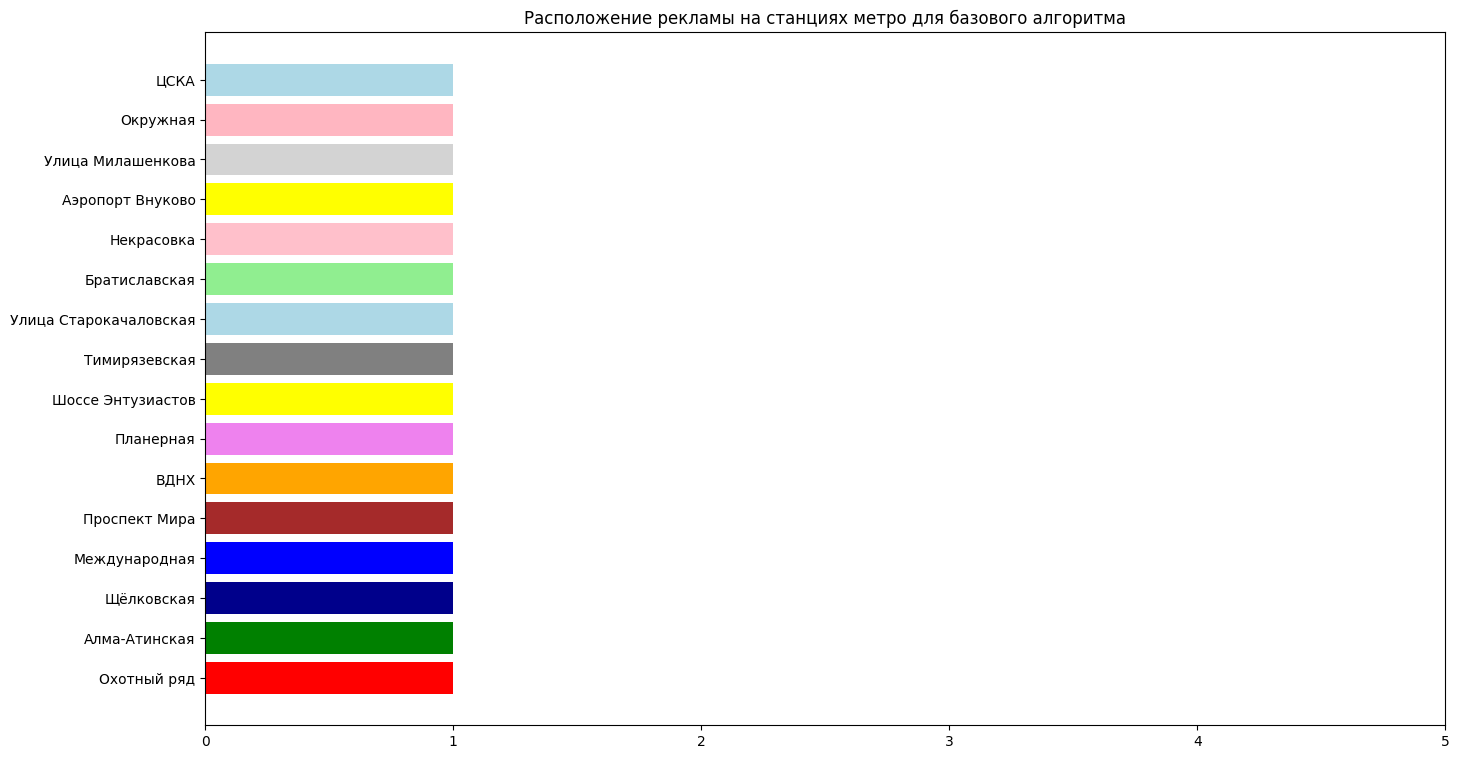

In [ ]:
fig, ax = plt.subplots(figsize =(16, 9))
names, counts = zip(*dict(ans_array).items())

custom_color = ["red", "green", "darkblue", "blue", "brown", "orange", "violet","yellow", "grey","lightblue", "lightgreen","pink", "yellow", "lightgrey", "lightpink", "lightblue"]

ax.barh(names, counts, color=custom_color)

ax.set_title('Расположение рекламы на станциях метро для базового алгоритма')

plt.xticks(range(6))
plt.show()


**Вывод:** большинство оптимальных для расположения рекламы станций удалены от центра. Тем не менее, мы задействуем две крупные центральные станции, несмотря на более высокую стоимость,  — "Охотный ряд" и "Проспект Мира", что способствует привлечению большего количества студентов. В совокупности, такая политика позволяет не только минимизировать издержки, но и увеличивать охваты.

# Вариации алгоритма

## 1.Изменение количества студентов, которых будем обучать:
*(от 100 до 500 тыс. человек)*

In [ ]:
ans = cp.Variable((31,16),integer = True)
obj_1 = cp.Maximize(100*(cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans))) - cp.sum(cp.multiply(matrix_costs,ans)))
constraints_1 = [
    cp.sum(cp.multiply(matrix_costs,ans)) <= 15000000,
    cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans)) <= 500000
]
for i in range(31):
    for j in range(16):
        constraints_1.append(ans[i][j] <=5)
        constraints_1.append(ans[i][j] >=0)
        constraints_1.append(ans[i][j] <=matrix[i][j])
for k in range(16):
    constraints_1.append(cp.sum(ans[:,k]) >= 1)

problem_1 = cp.Problem(obj_1, constraints_1)
problem_1.solve()
ans_1 = obj_1.value
print('Станции, на которых необходимо расположить рекламу:','\n')
print(ans.value,'\n')
print(f'Суммарная полученная прибыль (в рублях): {ans_1}')

Станции, на которых необходимо расположить рекламу: 

[[0. 1. 0. 0. 1. 5. 0. 1. 1. 1. 2. 1. 1. 0. 1. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
ans_array = []
for i in range(16):
    data = metro_actual_2[metro_actual_2['Line_id'] == i+1]
    for j in range(31):
        if ans.value[j][i]!=0:
             ans_array.append((data.iloc[j]['NameOfStation'],ans.value[j][i]))
        else:
             continue
print('Станции, на которых необходимо расположить рекламу:','\n')
for i in range(len(ans_array)):
    print(ans_array[i],'\n')

Станции, на которых необходимо расположить рекламу: 

('Юго-Западная', 5.0) 

('Домодедовская', 1.0) 

('Бауманская', 3.0) 

('Выставочная', 1.0) 

('Комсомольская', 1.0) 

('ВДНХ', 5.0) 

('Текстильщики', 5.0) 

('Новогиреево', 1.0) 

('Бульвар Дмитрия Донского', 1.0) 

('Улица Старокачаловская', 1.0) 

('Люблино', 2.0) 

('Некрасовка', 1.0) 

('Рассказовка', 1.0) 

('Тимирязевская', 1.0) 

('Ростокино', 1.0) 

('Текстильщики', 1.0) 



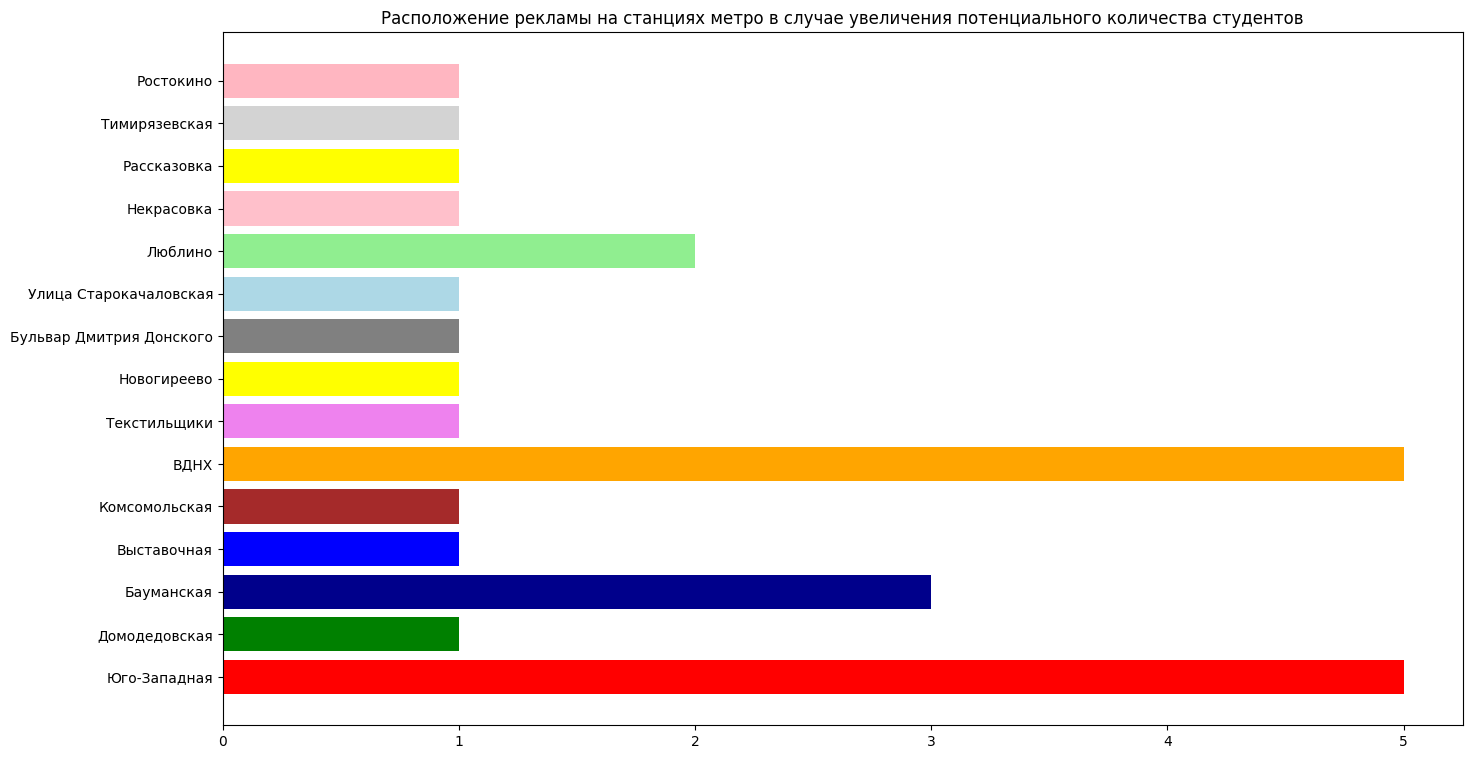

In [ ]:
fig, ax = plt.subplots(figsize =(16, 9))
names, counts = zip(*dict(ans_array).items())

ax.barh(names, counts, color=custom_color)

ax.set_title('Расположение рекламы на станциях метро в случае увеличения потенциального количества студентов')

plt.show()

**Вывод:** распределение значительно изменяется по сравнению с базовым алгоритмом: большее число станций с большим пассажиропотоком включено в решение задачи ("Комсомольская", "Тимирязевская", "ВДНХ"). Таким образом, можно сделать вывод о том, что при значительном увеличении потенциального количества привлекаемых студентов  отдача от большего пассажиропотока на станции превышает потери от высоких издержек на рекламу. Также заметим, что прибыль увеличилась в большее количество раз, чем количество студентов на курсе.


## 2.Изменение стоимости рекламы:
*От 150 до 125 тыс. рублей в центральной зоне (внутри Кольцевой линии)*

In [ ]:
for station in stations:
  if station in in_ring:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 125000
  elif station in in_bkl:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 100000
  else:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 75000

In [ ]:
list_ = [[]] * 16
for i in range(len(metro_actual_2)):
  list_[metro_actual_2.iloc[i]['Line_id'] - 1] = list_[metro_actual_2.iloc[i]['Line_id'] - 1] + [metro_actual_2.iloc[i]['Cost']]

matrix_costs = np.zeros((31,16))
for i in range(16):
  for j in range(len(list_[i])):
    matrix_costs[j][i] = list_[i][j]


In [ ]:
ans = cp.Variable((31,16),integer = True)
obj_1 = cp.Maximize(100*(cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans))) - cp.sum(cp.multiply(matrix_costs,ans)))
constraints_1 = [
    cp.sum(cp.multiply(matrix_costs,ans)) <= 15000000,
    cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans)) <= 100000
]
for i in range(31):
    for j in range(16):
        constraints_1.append(ans[i][j] <=5)
        constraints_1.append(ans[i][j] >=0)
        constraints_1.append(ans[i][j] <=matrix[i][j])
for k in range(16):
    constraints_1.append(cp.sum(ans[:,k]) >= 1)

problem_1 = cp.Problem(obj_1, constraints_1)
problem_1.solve()
ans_1 = obj_1.value
print('Станции, на которых необходимо расположить рекламу:','\n')
print(ans.value,'\n')
print(f'Суммарная полученная прибыль (в рублях): {ans_1}')

Станции, на которых необходимо расположить рекламу: 

[[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
ans_array = []
for i in range(16):
    data = metro_actual_2[metro_actual_2['Line_id'] == i+1]
    for j in range(31):
        if ans.value[j][i]!=0:
             ans_array.append((data.iloc[j]['NameOfStation'],ans.value[j][i]))
        else:
             continue
print('Станции, на которых необходимо расположить рекламу:','\n')
for i in range(len(ans_array)):
    print(ans_array[i],'\n')

Станции, на которых необходимо расположить рекламу: 

('Охотный ряд', 1.0) 

('Сокол', 1.0) 

('Мякинино', 1.0) 

('Выставочная', 1.0) 

('Комсомольская', 1.0) 

('Медведково', 1.0) 

('Спартак', 1.0) 

('Перово', 1.0) 

('Отрадное', 1.0) 

('Улица Старокачаловская', 1.0) 

('Физтех', 1.0) 

('Некрасовка', 1.0) 

('Озёрная', 1.0) 

('Выставочный центр', 1.0) 

('Стрешнево', 1.0) 

('Новаторская', 1.0) 



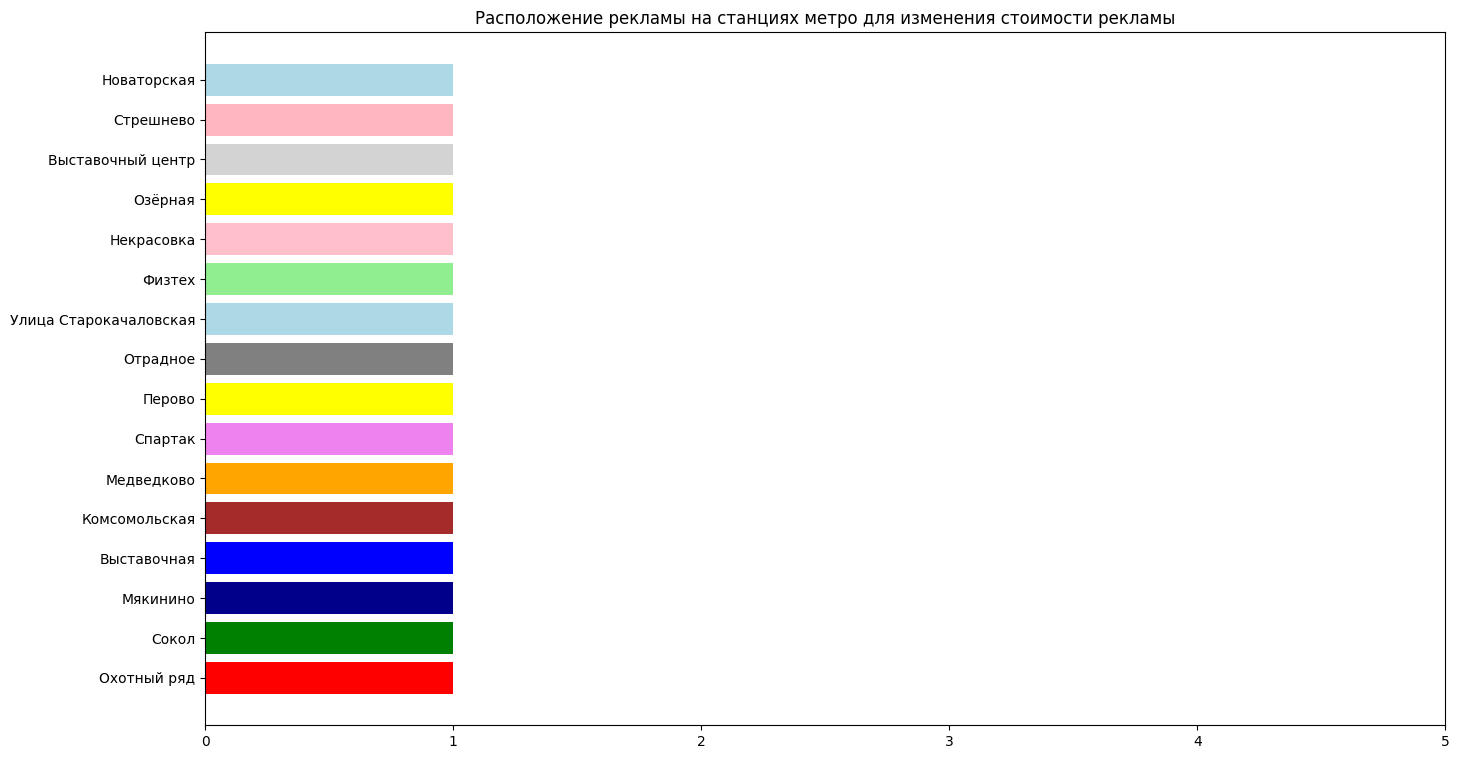

In [ ]:
fig, ax = plt.subplots(figsize =(16, 9))
names, counts = zip(*dict(ans_array).items())

ax.barh(names, counts, color=custom_color)

ax.set_title('Расположение рекламы на станциях метро при изменении стоимости рекламы')

plt.xticks(range(6))
plt.show()

**Вывод:** распределение изменяется незначительно. Главное отличие от базового алгоритма состоит в том, что в данном случае в решении увеличивается количество центральных станций с более дорогой рекламой ("Комсомольская", "Охотный ряд"). Также прибыль в данном случае выше по сравнению с базовой моделью, что очевидно.

## 3.Изменение бюджета на рекламу
*От 15 до 5 млн рублей*



In [ ]:
for station in stations:
  if station in in_ring:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 150000
  elif station in in_bkl:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 100000
  else:
    metro_actual_2.loc[metro_actual_2['NameOfStation'] == station, 'Cost'] = 75000

In [ ]:
list_ = [[]] * 16
for i in range(len(metro_actual_2)):
  list_[metro_actual_2.iloc[i]['Line_id'] - 1] = list_[metro_actual_2.iloc[i]['Line_id'] - 1] + [metro_actual_2.iloc[i]['Cost']]

matrix_costs = np.zeros((31,16))
for i in range(16):
  for j in range(len(list_[i])):
    matrix_costs[j][i] = list_[i][j]

In [ ]:
ans = cp.Variable((31,16),integer = True)
obj_1 = cp.Maximize(100*(cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans))) - cp.sum(cp.multiply(matrix_costs,ans)))
constraints_1 = [
    cp.sum(cp.multiply(matrix_costs,ans)) <= 5000000,
    cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans)) <= 100000
]
for i in range(31):
    for j in range(16):
        constraints_1.append(ans[i][j] <=5)
        constraints_1.append(ans[i][j] >=0)
        constraints_1.append(ans[i][j] <=matrix[i][j])
for k in range(16):
    constraints_1.append(cp.sum(ans[:,k]) >= 1)

problem_1 = cp.Problem(obj_1, constraints_1)
problem_1.solve()
ans_1 = obj_1.value
print('Станции, на которых необходимо расположить рекламу:','\n')
print(ans.value,'\n')
print(f'Суммарная полученная прибыль (в рублях): {ans_1}')

Станции, на которых необходимо расположить рекламу: 

[[1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
ans_array = []
for i in range(16):
    data = metro_actual_2[metro_actual_2['Line_id'] == i+1]
    for j in range(31):
        if ans.value[j][i]!=0:
             ans_array.append((data.iloc[j]['NameOfStation'],ans.value[j][i]))
        else:
             continue
print('Станции, на которых необходимо расположить рекламу:','\n')
for i in range(len(ans_array)):
    print(ans_array[i],'\n')

Станции, на которых необходимо расположить рекламу: 

('Охотный ряд', 1.0) 

('Алма-Атинская', 1.0) 

('Щёлковская', 1.0) 

('Международная', 1.0) 

('Проспект Мира', 1.0) 

('ВДНХ', 1.0) 

('Планерная', 1.0) 

('Шоссе Энтузиастов', 1.0) 

('Тимирязевская', 1.0) 

('Улица Старокачаловская', 1.0) 

('Братиславская', 1.0) 

('Некрасовка', 1.0) 

('Аэропорт Внуково', 1.0) 

('Улица Милашенкова', 1.0) 

('Окружная', 1.0) 

('ЦСКА', 1.0) 



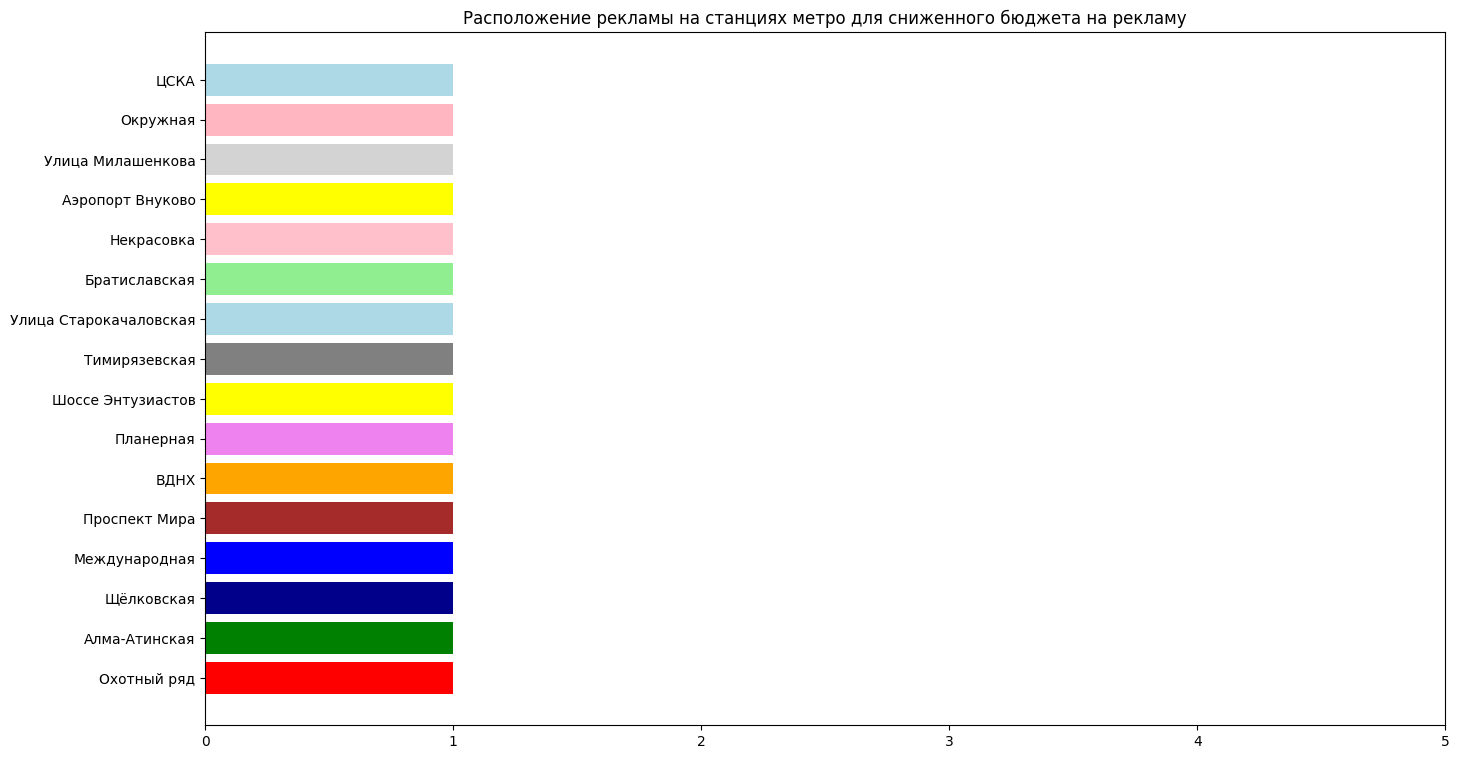

In [ ]:
fig, ax = plt.subplots(figsize =(16, 9))
names, counts = zip(*dict(ans_array).items())

ax.barh(names, counts, color=custom_color)

ax.set_title('Расположение рекламы на станциях метро для сниженного бюджета на рекламу')

plt.xticks(range(6))
plt.show()

**Вывод:** полученное решение полностью совпадает с решением при использовании базового алгоритма. Таким образом, при исходном количестве студентов(100 тыс.) потенциальное увеличение затрат на рекламу, а именно, размещение рекламы на станциях с большим "студентопотком", не имеет смысла, так как разность выручки и издержек (=прибыль) в данном случае не увеличивается. Так оптимальным решением является оставить распределение рекламы при сокращении бюджета на рекламу втрое при данном количестве студентов.




# Усложнение алгоритма

Попробуем усложнить задачу и ввести коэффициенты, отвечающие за склонность студентов приобрести курс компании в зависимости от рейтинга университета. Студенты из университета, занимающего 1-ое место в рейтинге, будут более заинтересованы в курсе, поэтому станции, на которой расположен их университет/общежитие, мы присвоим коэффициент 1,5. Станции, на которых находятся университеты (или их общежития), занимающие места 2,3,4,5 будут присвоены коэффициенты 1.4, 1.3, 1.2, 1.1, соответственно.

*В случае, если на станции расположено несколько университетов из топ-5, ей будет присвоен коэффициент университета, занимающего наивысшее место в рейтинге.*


Для этого загрузим новую таблицу и проведем похожие преобразования как в прошлый раз:




In [ ]:
url = 'https://raw.githubusercontent.com/TatianaSoboleva/-/main/uni_and_dorms_new.csv'
unidorms = pd.read_csv(url, delimiter = ',')
unidorms.head()
def f(row):
  if row['Rating'] == 1:
      return 1.5
  elif row['Rating'] == 2:
      return 1.4
  elif row['Rating'] == 3:
      return 1.3
  elif row['Rating'] == 4:
      return 1.2
  else :
      return 1.1
unidorms['Rating_coef'] = unidorms.apply(f, axis=1)
unidorms.head(5)

,Название,Метро,Rating,Rating_coef
0,Московский государственный университет имени М...,Университет,1,1.5
1,Московский государственный университет имени М...,Библиотека имени Ленина,1,1.5
2,Московский государственный университет имени М...,Охотный ряд,1,1.5
3,Московский государственный технический универс...,Бауманская,2,1.4
4,Московский государственный технический универс...,Речной вокзал,2,1.4


In [ ]:
unidorms_1 = unidorms['Метро'].value_counts().to_frame()
unidorms_1.reset_index(inplace= True)
unidorms_1 = unidorms_1.rename(columns={'index': 'NameStation', 'Метро': 'Quantity'})

unidorms_pred = unidorms[['Метро','Rating_coef']]
unidorms_2 = unidorms_pred.groupby(['Метро']).max()
unidorms_2.reset_index(inplace= True)
unidorms_2 = unidorms_2.rename(columns={'Метро': 'NameStation'})
unidorms_2.head(5)

,NameStation,Rating_coef
0,Авиамоторная,1.3
1,Бауманская,1.4
2,Библиотека имени Ленина,1.5
3,ВДНХ,1.3
4,Владыкино,1.2


In [ ]:
metro_actual_2 = metro_actual_2.merge(unidorms_2, left_on = 'NameOfStation', right_on = 'NameStation', how = 'left')

In [ ]:
metro_actual_2['Rating_coef'] = metro_actual_2['Rating_coef'].fillna(1)
metro_actual_2.head(5)

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7,Line_id,Cost,NameStation_x,Quantity,university_flg,conversions_1,NameStation_y,Rating_coef
0,Комсомольская,Кольцевая линия,2023,III квартал,8420305.0,6691692.0,2630091456,NaN,5,150000.0,Комсомольская,2.0,1,0.004,Комсомольская,1.3
1,ВДНХ,Калужско-Рижская линия,2023,III квартал,6811166.0,6378959.0,2625907197,NaN,6,75000.0,ВДНХ,1.0,1,0.003,ВДНХ,1.3
2,Щёлковская,Арбатско-Покровская линия,2023,III квартал,6304487.0,5922637.0,2625907121,NaN,3,75000.0,NaN,NaN,1,0.002,NaN,1.0
3,Новогиреево,Калининская линия,2023,III квартал,5650771.0,5472536.0,2625907186,NaN,8,75000.0,NaN,NaN,1,0.002,NaN,1.0
4,Выхино,Таганско-Краснопресненская линия,2023,III квартал,5445897.0,5212132.0,2625907480,NaN,7,75000.0,NaN,NaN,1,0.002,NaN,1.0


Матрица с коэффициентами значимости университетов

In [ ]:
list_ = [[]] * 16
for i in range(len(metro_actual_2)):
  list_[metro_actual_2.iloc[i]['Line_id'] - 1] = list_[metro_actual_2.iloc[i]['Line_id'] - 1] + [metro_actual_2.iloc[i]['Rating_coef']]

matrix_universities = np.zeros((31,16))
for i in range(16):
  for j in range(len(list_[i])):
    matrix_universities[j][i] = list_[i][j]

matrix_universities

array([[1.5, 1. , 1. , 1. , 1.3, 1.3, 1. , 1. , 1. , 1. , 1.3, 1. , 1. ,
        1. , 1. , 1. ],
       [1.2, 1. , 1. , 1. , 1.3, 1.3, 1.3, 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. ],
       [1. , 1. , 1.4, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.3, 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. ],
       [1.3, 1. , 1. , 1. , 1.2, 1. , 1.3, 1.3, 1. , 1. , 1.3, 1. , 1. ,
        1. , 1. , 1.3],
       [1.5, 1. , 1. , 1. , 1.3, 1.3, 1. , 1. , 1. , 1. , 1. , 1.3, 1. ,
        1. , 1. , 1. ],
       [1.3, 1.2, 1. , 1. , 1. , 1. , 1. , 1.3, 1. , 1. , 1. , 1. , 1. ,
        0. , 1. , 1.4],
       [1.5, 1.3, 1.4, 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. ,
        0. , 1. , 1. ],
       [1.3, 1. , 1.3, 1. , 1. , 1. , 1. , 0. , 1. , 0. , 1. , 0. , 1. ,
        0. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 0. , 1. , 0. , 1. ,
        0. , 1. , 1. ],
       [1.3, 1. , 1. , 1.3, 1.

In [ ]:
ans = cp.Variable((31,16),integer = True)
obj_2 = cp.Maximize(100*cp.sum(cp.multiply(cp.multiply(cp.multiply(matrix,matrix_conversions),matrix_universities),ans)) - cp.sum(cp.multiply(matrix_costs,ans)))
constraints_2 = [
    cp.sum(cp.multiply(matrix_costs,ans)) <= 15000000,
    cp.sum(cp.multiply(cp.multiply(matrix,matrix_conversions),ans)) <= 100000
]
for i in range(31):
    for j in range(16):
        constraints_2.append(ans[i][j] <=5)
        constraints_2.append(ans[i][j] >=0)
        constraints_2.append(ans[i][j] <=matrix[i][j])
for k in range(16):
    constraints_2.append(cp.sum(ans[:,k]) >= 1)

problem_2 = cp.Problem(obj_2, constraints_2)
problem_2.solve()
ans_2 = obj_2.value
print('Станции, на которых необходимо расположить рекламу:','\n')
print(ans.value,'\n')
print(f'Суммарная полученная прибыль (в рублях): {ans_2}')

Станции, на которых необходимо расположить рекламу: 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.

In [ ]:
ans_array = []
for i in range(16):
    data = metro_actual_2[metro_actual_2['Line_id'] == i+1]
    for j in range(31):
        if ans.value[j][i]!=0:
             ans_array.append((data.iloc[j]['NameOfStation'],ans.value[j][i]))
        else:
             continue
print('Станции, на которых необходимо расположить рекламу:','\n')
for i in range(len(ans_array)):
    print(ans_array[i],'\n')

Станции, на которых необходимо расположить рекламу: 

('Университет', 3.0) 

('Речной вокзал', 1.0) 

('Измайловская', 1.0) 

('Кунцевская', 1.0) 

('Курская', 1.0) 

('Ясенево', 1.0) 

('Спартак', 1.0) 

('Шоссе Энтузиастов', 1.0) 

('Севастопольская', 1.0) 

('Лесопарковая', 1.0) 

('Физтех', 1.0) 

('Окская', 1.0) 

('Пыхтино', 1.0) 

('Улица Сергея Эйзенштейна', 1.0) 

('Белокаменная', 1.0) 

('Проспект Вернадского', 1.0) 



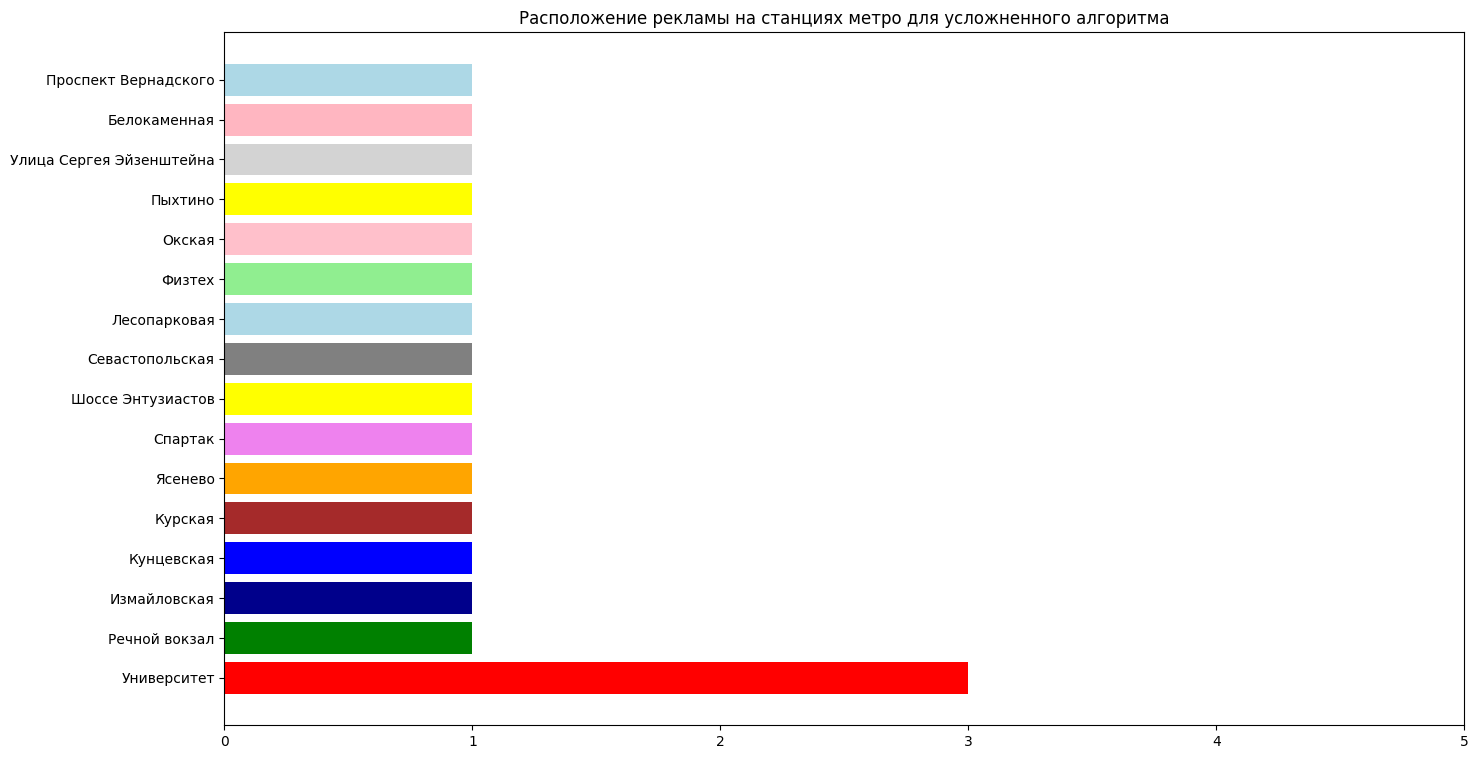

In [ ]:
fig, ax = plt.subplots(figsize =(16, 9))
names, counts = zip(*dict(ans_array).items())

ax.barh(names, counts, color=custom_color)

ax.set_title('Расположение рекламы на станциях метро для усложненного алгоритма')

plt.xticks(range(6))
plt.show()

**Вывод:** распределение изменяется относительно базовой модели, так как теперь становится еще более выгодно размещать рекламу на станциях, где расположены университеты с наивысшим рейтингом. Например, в их число входит "Университет", где находится несколько учебных корпусов и общежитий МГУ, занимающего 1-ое место в используемом рейтинге. Так введение новой предпосылки позволило придать больший вес станциям, на которых расположены университеты, нивелировав высокие издержки на рекламу на них.


# Подведение итогов

1.   Набор выбранных для размещения рекламы станций зависит от нескольких признаков: стоимость рекламы, наличие университета рядом со станцией и склонность студентов этого университета к покупке обучающих курсов.

2. При относительно дорогой рекламе в центре выгоднее всего выбирать окраинные станции, где большой «студентопоток» (например, "Текстильщики").

3. Размер компании, привлекающей студентов, оказывает сильное влияние на выбор станций - более крупные компании могут позволить себе более дорогую рекламу в более популярном месте.

4. Наибольшая прибыль была получена в случае, когда в модели было увеличено количество студентов на курсе.

5. Данный алгоритм может быть применен для решения любой подобной задачи, где цель состоит в повышении охвата рекламы в Московском метро.
